In [8]:
# ---
# title: Data Analysis and Visualization
# author: Your Name
# date: 2023-09-09
# ---

# Setup

import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib import dates as mdates

# functions

# Define a function to remove outliers
def remove_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]


# we use a centered moving average to smooth the data withour introducing a lag
def centered_moving_average(data, window_size):
    """Compute a centered moving average."""
    half_window = window_size // 2
    extended_data = np.pad(data, (half_window, half_window), mode='edge')
    cumsum = np.cumsum(extended_data)
    
    # Subtract the cumulated sum shifted by the window size from the cumulated sum 
    # to get the sum over the window for each point
    sum_window = cumsum[window_size:] - cumsum[:-window_size]
    return sum_window / window_size

In [9]:
# Step 0: Load Data
external_temps = {}
with open('temperature_2023-09-06_14-59-14.log', 'r', encoding='utf-8') as f:
    for line in f:
        if line.strip():  # Check if line is not empty
            parts = line.split('\t')
            timestamp = dt.datetime.strptime(parts[0], '%Y-%m-%d %H:%M:%S')
            for part in parts[1:]:
                if ':' in part:
                    module, temp = part.split(':')
                    module = module.strip()
                    temp = float(temp.strip())
                    if module not in external_temps:
                        external_temps[module] = []
                    external_temps[module].append((timestamp, temp))
# Step 2: Adjust the timestamps
for module, data in external_temps.items():
    adjusted_data = []
    for timestamp, temp in data:
        adjusted_data.append((timestamp + dt.timedelta(hours=2), temp))
    external_temps[module] = adjusted_data

with open('tstCDC_2023_09_06-17_01_11.txt', 'r', encoding="utf-8" ) as f:
    data_str = f.read()

data = np.array([list(map(float, line.split())) for line in data_str.split('\n') if line])

V1, V2, R = data[:,0], data[:,1], data[:,2]

# Step 4: Align the data
start_time = dt.datetime(2023, 9, 6, 17, 1, 11)  # Start time from your data
aligned_temps = {module: [] for module in external_temps}
for module, data in external_temps.items():
    current_idx = 0
    for second in range(len(V1)):  # Assuming V1 is the array you provided in the code snippet
        current_time = start_time + dt.timedelta(seconds=second)
        while current_idx < len(data) - 1 and data[current_idx + 1][0] <= current_time:
            current_idx += 1
        aligned_temps[module].append(data[current_idx][1])

# smoothed controller temperature to 1000 points
controller_temp_smoothed = centered_moving_average(aligned_temps['controller'], 1000)


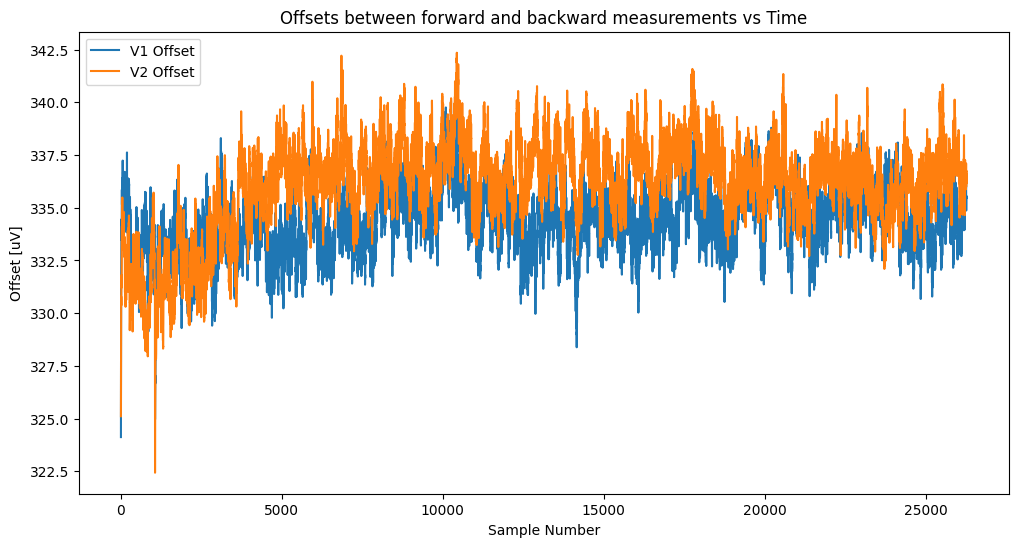

In [10]:


V1_offset = (V1[::2] + V1[1::2]) / 2  
V2_offset = (V2[::2] + V2[1::2]) / 2

V1_no_offset = V1 - np.repeat(V1_offset, 2)
V2_no_offset = V2 - np.repeat(V2_offset, 2)

V_final = np.absolute((V1_no_offset + V2_no_offset) / 2) 
# Step 2: Convert Resistance to Temperature (simplified for example)
Temperature = (R - 100) / 0.385  # A simple linear relationship for PT100 between 0°C and 100°C
 
# Create an array for lags
lags = np.arange(-len(V_final) + 1, len(V_final))

# Convert V_final to ppm
V_final_avg = np.mean(V_final)
V_final_ppm = (V_final - V_final_avg) * 1e6 / V_final_avg

# Define a function to remove outliers
def remove_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

V_final_ppm_filtered = remove_outliers(V_final_ppm)

V_final_ppm_filtered_avg = centered_moving_average(V_final_ppm_filtered, 100)

# Plot the offsets vs time
plt.figure(figsize=(12, 6))
plt.plot(V1_offset*1e6, label='V1 Offset')
plt.plot(V2_offset*1e6, label='V2 Offset')
plt.title('Offsets between forward and backward measurements vs Time')
plt.xlabel('Sample Number')
plt.ylabel('Offset [uV]')
plt.legend()
plt.savefig('img/offsets_vs_time.png')
plt.show()


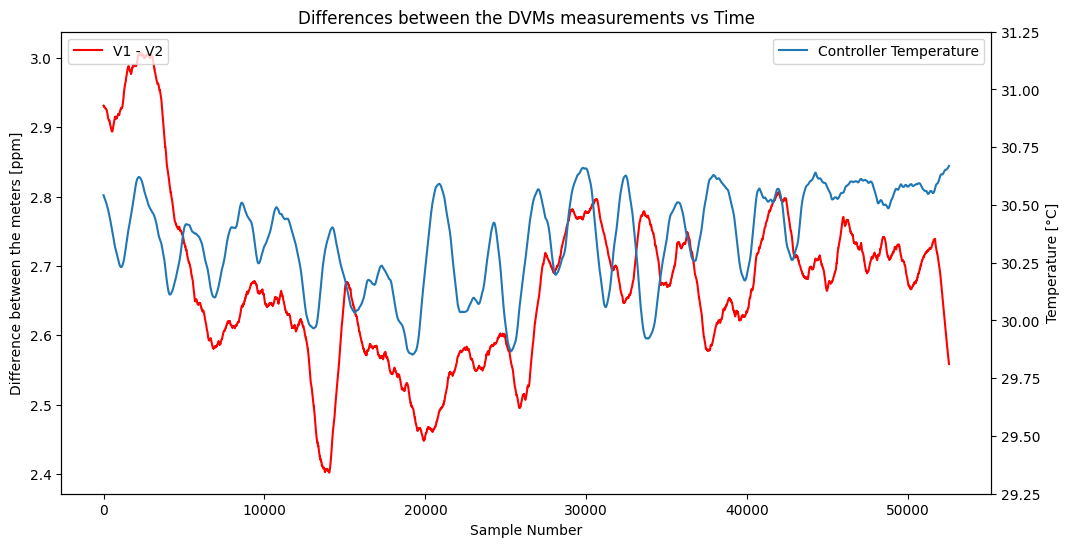

Average ppm deviation:  2.672252502911391
Maximum ppm excursion:  1.020139230621333


In [11]:
# we want to calculate the ppm deviation of the difference of the meters with respect to the mean of V_final

ppm_deviation = np.absolute(V1_no_offset - V2_no_offset) * 1e6 / V_final_avg
ppm_deviation_smoothed = centered_moving_average(ppm_deviation, 1000)

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(ppm_deviation_smoothed, label='V1 - V2', color='r')
ax1.set_xlabel('Sample Number')
ax1.set_ylabel('Difference between the meters [ppm]')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
# use the nicer blue from the seaborn color palette
ax2.plot(controller_temp_smoothed, label='Controller Temperature', color='C0')
ax2.set_ylabel('Temperature [°C]')
# set the limits of the y axis
ax2.set_ylim([29.25, 31.25])
ax2.legend(loc='upper right')

plt.title('Differences between the DVMs measurements vs Time')

plt.savefig('img/differences_V1_V2_vs_time.png')

plt.show()

# print average ppm deviation
print('Average ppm deviation: ', np.mean(ppm_deviation))
# print maximum ppm excursion
print('Maximum ppm excursion: ', np.max(ppm_deviation) - np.min(ppm_deviation))

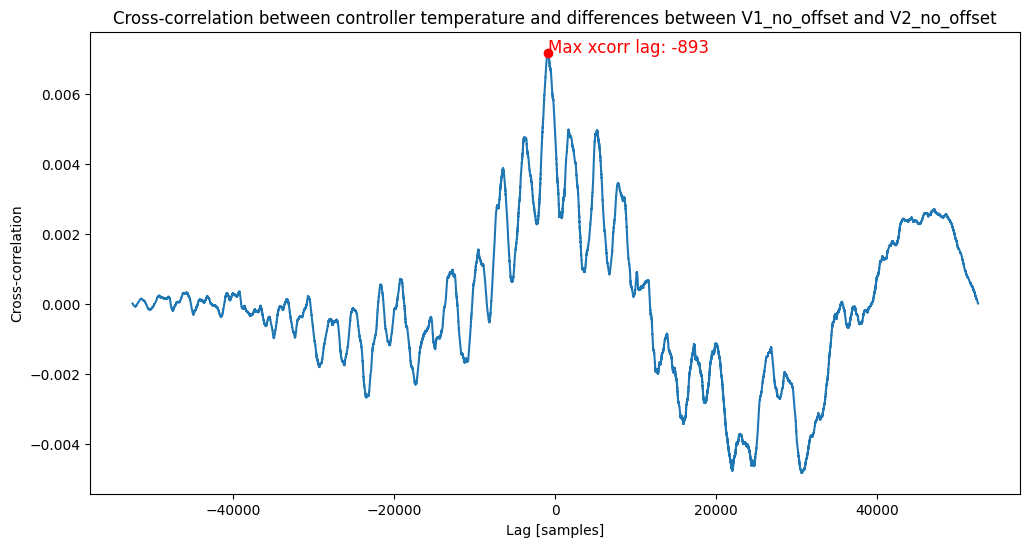

In [12]:
# we now want to measure the lag between the controller temperature and the differences between V1_no_offset and V2_no_offset
# we use cross-correlation to do that

# Compute the cross-correlation between the controller temperature and the differences between V1_no_offset and V2_no_offset
cross_corr = np.correlate(aligned_temps['controller']-np.average(aligned_temps['controller']), np.absolute(V1 - V2)-np.average( np.absolute(V1 - V2)), mode='full')
# create the lags array
lags = np.arange(-len(V_final) + 1, len(V_final))

# Plot the cross-correlation
plt.figure(figsize=(12, 6))
plt.plot(lags, cross_corr)

# highlight the maximum cross-correlation
max_corr_idx = np.argmax(cross_corr)
plt.plot(lags[max_corr_idx], cross_corr[max_corr_idx], 'ro')
plt.text(lags[max_corr_idx], cross_corr[max_corr_idx], f'Max xcorr lag: {lags[max_corr_idx]}', fontsize=12, color='r')

plt.title('Cross-correlation between controller temperature and differences between V1_no_offset and V2_no_offset')
plt.xlabel('Lag [samples]')
plt.ylabel('Cross-correlation')

plt.savefig('img/cross_correlation_temperature_and_V1-V2.png')

plt.show()


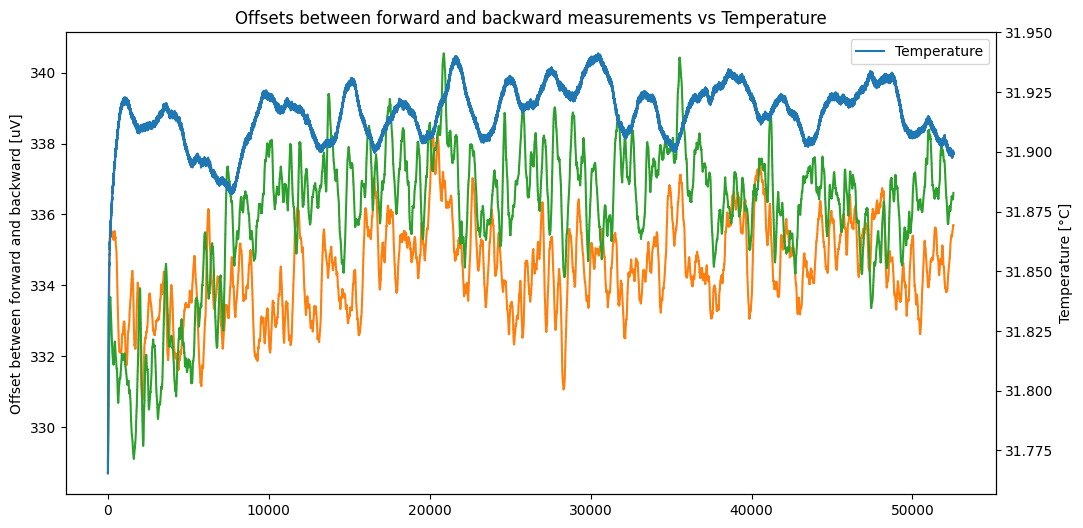

In [13]:
# Plot the two offsets to compare with resistor Temperature
plt.figure(figsize=(12, 6))
# use two different y-axis
ax1 = plt.gca()
ax2 = ax1.twinx() 
# filter the offsets 
V1_offset_filtered = centered_moving_average(V1_offset, 100)
V2_offset_filtered = centered_moving_average(V2_offset, 100)

ax1.plot(np.repeat(V1_offset_filtered*1e6,2), label='V1 Offset', color='C1')
ax1.plot(np.repeat(V2_offset_filtered*1e6,2), label='V2 Offset', color='C2')
ax1.set_ylabel('Offset between forward and backward [uV]')
ax2.plot(Temperature, label='Temperature', color='C0')
ax2.set_ylabel('Temperature [°C]')

plt.xlabel('Sample Number')

plt.title('Offsets between forward and backward measurements vs Temperature')
plt.legend()
plt.savefig('img/offsets_vs_temperature.png')
plt.show()


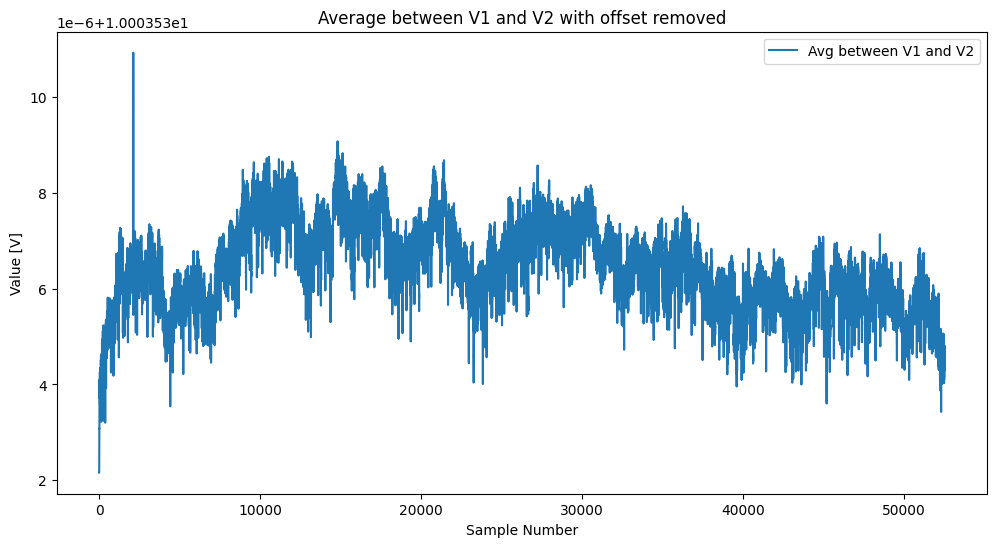

In [14]:

# Plot 1
plt.figure(figsize=(12, 6))
plt.plot(V_final, label='Avg between V1 and V2')
plt.title('Average between V1 and V2 with offset removed')
plt.xlabel('Sample Number')
plt.ylabel('Value [V]')
plt.legend()
plt.savefig('img/average_v_final_no_offset.png')
plt.show()


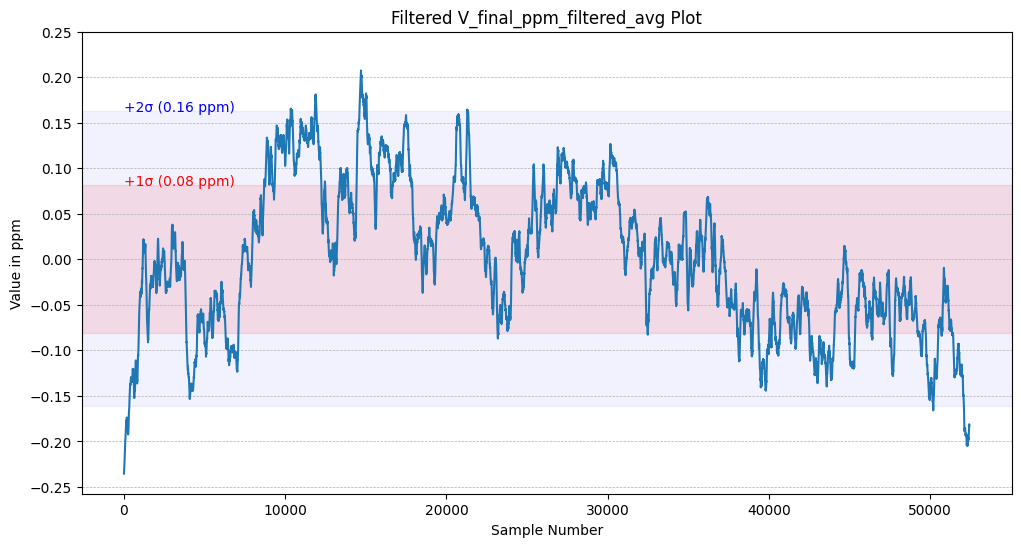

In [26]:

# Plot 2
plt.figure(figsize=(12, 6))
sigma = np.std(V_final_ppm_filtered_avg)
mean = np.mean(V_final_ppm_filtered_avg)

# 1 Sigma bands
plt.axhspan(mean - sigma, mean + sigma, color='red', alpha=0.1, label='1 Sigma') 
plt.text(0, mean + sigma, f'+1σ ({sigma:.2f} ppm)', color='r', horizontalalignment='left')

# 2 Sigma bands
plt.axhspan(mean - 2*sigma, mean + 2*sigma, color='blue', alpha=0.05, label='2 Sigma')
plt.text(0, mean + 2*sigma, f'+2σ ({2*sigma:.2f} ppm)',  color='b', horizontalalignment='left')

plt.plot(V_final_ppm_filtered_avg, label='V_final_ppm_filtered_avg')

ticks_interval = 0.05  # spacing in ppm
max_val = np.ceil(np.max(np.abs(V_final_ppm_filtered_avg)) / ticks_interval) * ticks_interval
y_ticks = np.arange(-max_val, max_val + ticks_interval, ticks_interval)
plt.yticks(y_ticks)

plt.grid(axis='y', linestyle='--', linewidth=0.5)

plt.title('Filtered V_final_ppm_filtered_avg Plot')
plt.xlabel('Sample Number')
plt.ylabel('Value in ppm')
plt.savefig('img/filtered_v_final_ppm_filtered_avg.png')
plt.show()


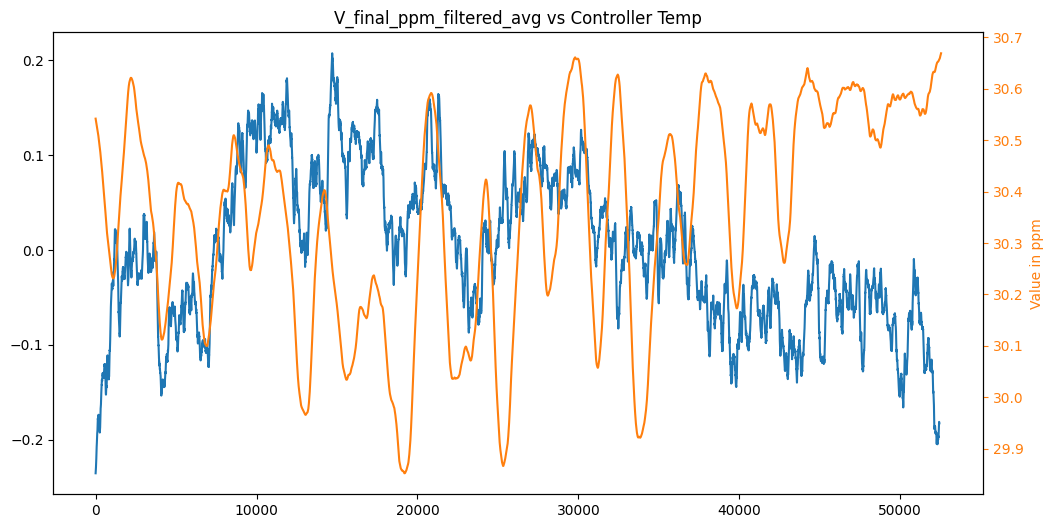

In [9]:

# Plot 3
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax1.plot(V_final_ppm_filtered_avg, label='V_final_ppm_filtered')

# Create a second y-axis to plot the controller temperature
if 'controller' in aligned_temps:
    ax2 = ax1.twinx() 
    ax2.plot(controller_temp_smoothed, label='Controller Temp', color='tab:orange')
    ax2.set_ylabel('Temperature (°C)', color='tab:orange')
    ax2.tick_params('y', colors='tab:orange')

plt.title('V_final_ppm_filtered_avg vs Controller Temp')
plt.xlabel('Sample Number')
plt.ylabel('Value in ppm')
plt.savefig('img/v_final_ppm_filtered_avg_vs_controller_temp.png')
plt.show()



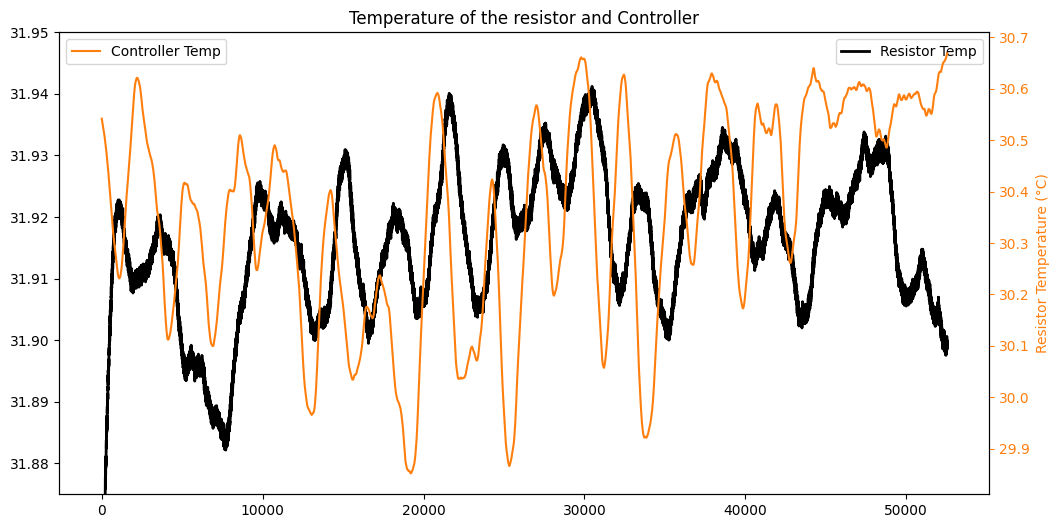

In [10]:

# Plot 4
plt.figure(figsize=(12, 6))
ax_temp = plt.gca()
ax_temp.plot(Temperature, label='Resistor Temp', color='k', linewidth=2)
# add legend to upper right corner
ax_temp.legend(loc="upper right")
# scale the resistor temperature to match the controller temperature
ax_temp.set_ylim([31.875, 31.95])

if 'controller' in aligned_temps:
    ax_controller = ax_temp.twinx()
    ax_controller.plot(controller_temp_smoothed, label='Controller Temp', color='tab:orange')
    ax_controller.set_ylabel('Controller Temperature (°C)', color='tab:orange')
    ax_controller.tick_params('y', colors='tab:orange')

plt.title('Temperature of the resistor and Controller')
plt.xlabel('Sample Number')
plt.ylabel('Resistor Temperature (°C)')
plt.legend(loc="upper left")
plt.savefig('img/resistor_temp_vs_controller_temp.png')
plt.show()

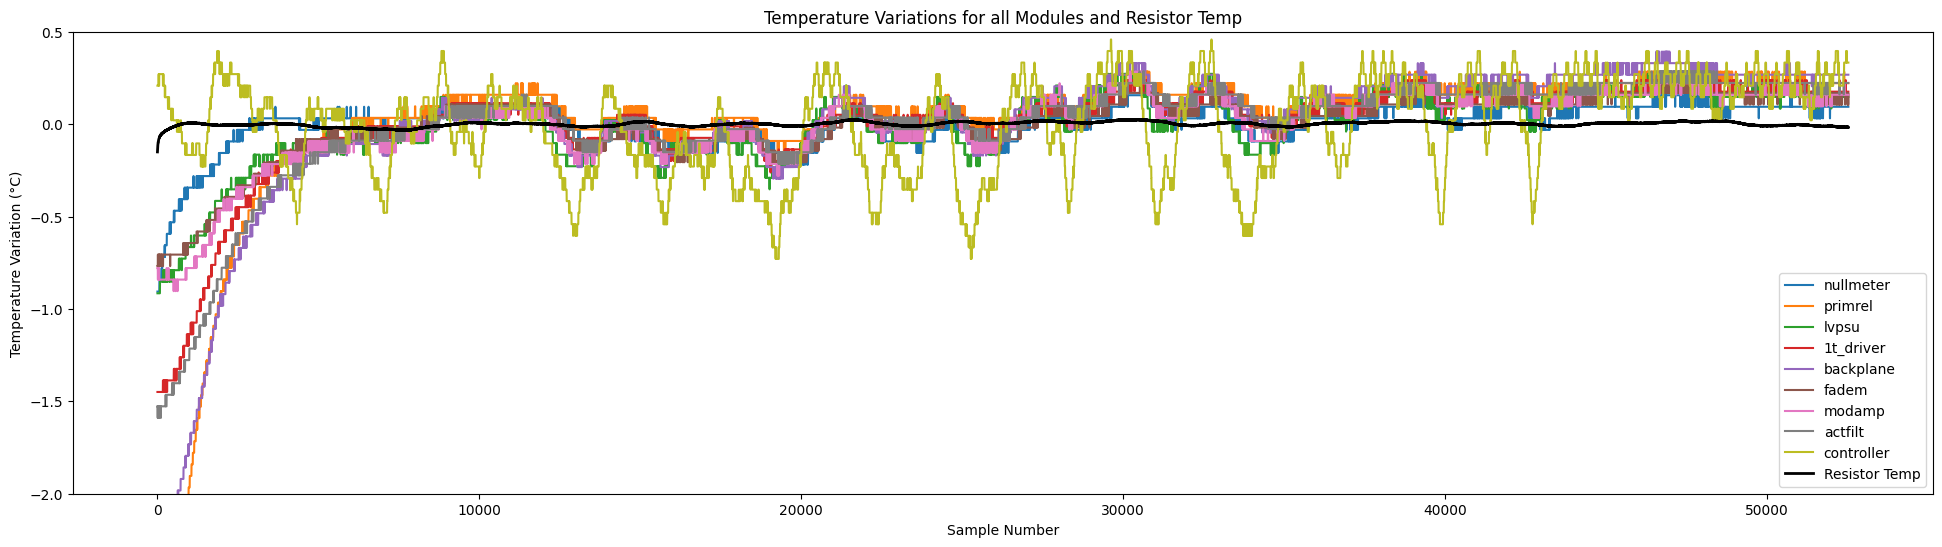

In [11]:
plt.figure(figsize=(24, 6))
# Calculate the mean value for Resistor Temperature as its set point
Temperature_normalized = Temperature - np.mean(Temperature)


# Plotting the normalized temperatures for the modules
for module, temps in aligned_temps.items():
  temps_normalized = np.array(temps) - np.mean(temps)
  plt.plot(temps_normalized, label=module)

# Plotting the normalized resistor temperature
plt.plot(Temperature_normalized, label='Resistor Temp', color='k', linewidth=2)

# force the y scale to be between -2 and 0.5
plt.ylim(-2, 0.5)

plt.xlabel('Sample Number')
plt.ylabel('Temperature Variation (°C)')
plt.legend()
plt.title('Temperature Variations for all Modules and Resistor Temp')
plt.savefig('img/temperature_variations.png')
plt.show()

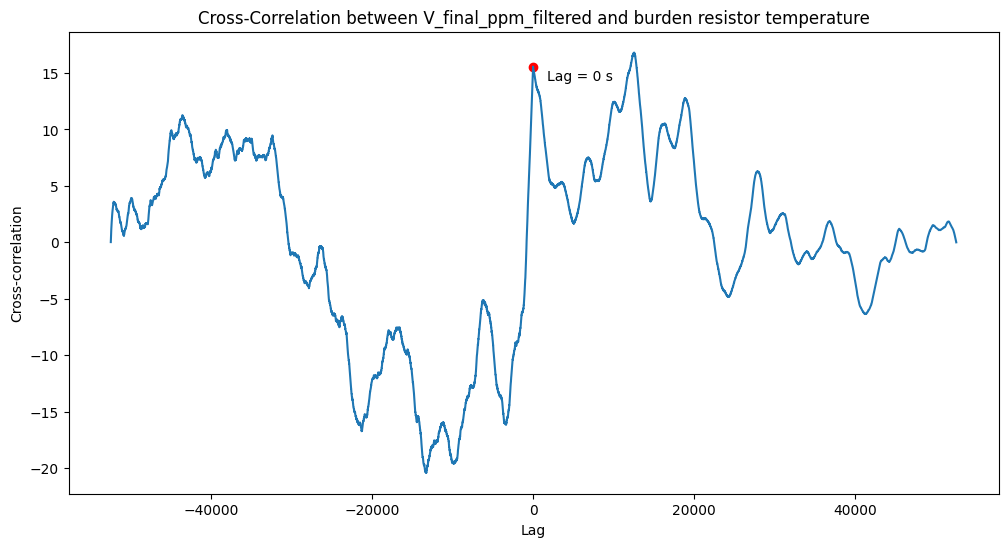

In [12]:
# Plotting for V_final_ppm_filtered and Temperature
plt.figure(figsize=(12, 6))
cross_corr_V_final = np.correlate(Temperature - np.mean(Temperature), 
                                 V_final_ppm_filtered - np.mean(V_final_ppm_filtered), 
                                 "full")
lags_V_final = np.arange(-len(V_final_ppm_filtered) + 1, len(Temperature))


search_range = 1000  # The range to search for the maximum value in the cross-correlation
# Find the index of the maximum value in the cross-correlation within the restricted range
restrict_range_indices = np.where((lags_V_final >= -search_range) & (lags_V_final <= search_range))
max_index_V_final_restricted = np.argmax(cross_corr_V_final[restrict_range_indices])
max_lag_V_final_restricted = lags_V_final[restrict_range_indices][max_index_V_final_restricted]

plt.plot(lags_V_final, cross_corr_V_final)
plt.scatter(max_lag_V_final_restricted, cross_corr_V_final[restrict_range_indices][max_index_V_final_restricted], color='red')  # highlight the max value with a red dot
plt.annotate(f'Lag = {max_lag_V_final_restricted} s',
             (max_lag_V_final_restricted, cross_corr_V_final[restrict_range_indices][max_index_V_final_restricted]),
             xytext=(10,-10), textcoords='offset points')
plt.title('Cross-Correlation between V_final_ppm_filtered and burden resistor temperature')
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.savefig('img/cross_correlation_V_final_ppm_filtered_and_burden_resistor_temp.png')
plt.show()

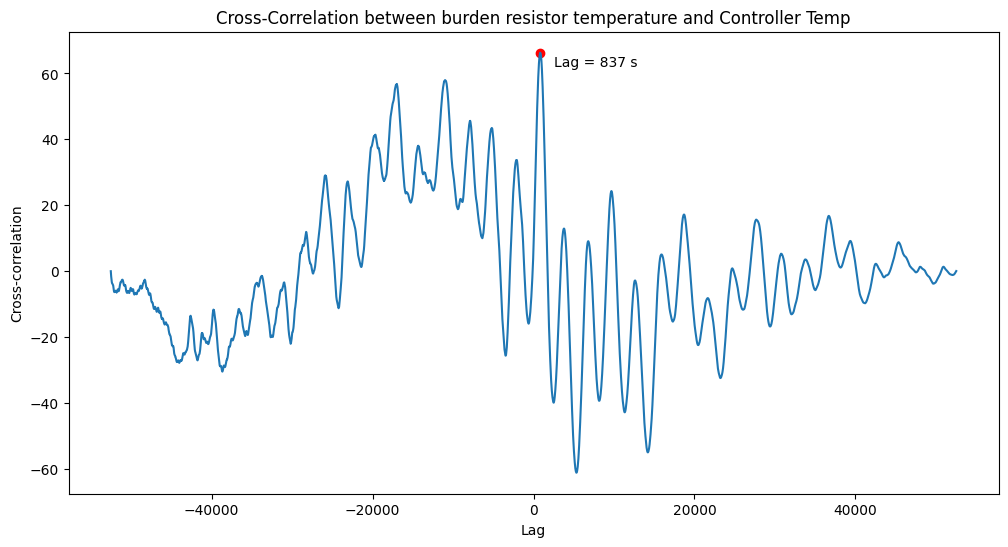

In [13]:

# Plotting for Temperature and Controller Temp
plt.figure(figsize=(12, 6))
cross_corr_temp_controller = np.correlate(Temperature - np.mean(Temperature), 
                                          aligned_temps['controller'] - np.mean(aligned_temps['controller']),
                                          "full")
lags_temp_controller = np.arange(-len(Temperature) + 1, len(aligned_temps['controller']))

# Find the index of the maximum value in the cross-correlation
max_index_temp_controller = np.argmax(cross_corr_temp_controller)
max_lag_temp_controller = lags_temp_controller[max_index_temp_controller]

plt.plot(lags_temp_controller, cross_corr_temp_controller)
plt.scatter(max_lag_temp_controller, cross_corr_temp_controller[max_index_temp_controller], color='red')  # highlight the max value with a red dot
plt.annotate(f'Lag = {max_lag_temp_controller} s',
             (max_lag_temp_controller, cross_corr_temp_controller[max_index_temp_controller]),
             xytext=(10,-10), textcoords='offset points')
plt.title('Cross-Correlation between burden resistor temperature and Controller Temp')
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.savefig('img/cross_correlation_burden_resistor_temp_and_controller_temp.png')
plt.show()